## Multiclass Trash Classification - TrashNet Dataset

---

*Author: Vian Sebastian Bromokusumo*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset

---

Since I have issues regarding my RAM, I have found the original dataset from (source). This dataset only consists of original images, while the baseline is already augmented.

In [ ]:
import os
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt

base_dir = '/content/drive/MyDrive/Colab Notebooks/adamata/dataset-resized'
print(os.listdir(base_dir))

['.DS_Store', 'cardboard', 'trash', 'paper', 'plastic', 'glass', 'metal']


Exploratory Image Analysis

---


Image Frequencies:
cardboard: 383
trash: 117
paper: 588
plastic: 482
glass: 481
metal: 390

Image Frequencies (Percentage):
cardboard: 15.690%
trash: 4.793%
paper: 24.088%
plastic: 19.746%
glass: 19.705%
metal: 15.977%

Example Image Sizes by Class:
cardboard: (384, 512, 3)
trash: (384, 512, 3)
paper: (384, 512, 3)
plastic: (384, 512, 3)
glass: (384, 512, 3)
metal: (384, 512, 3)


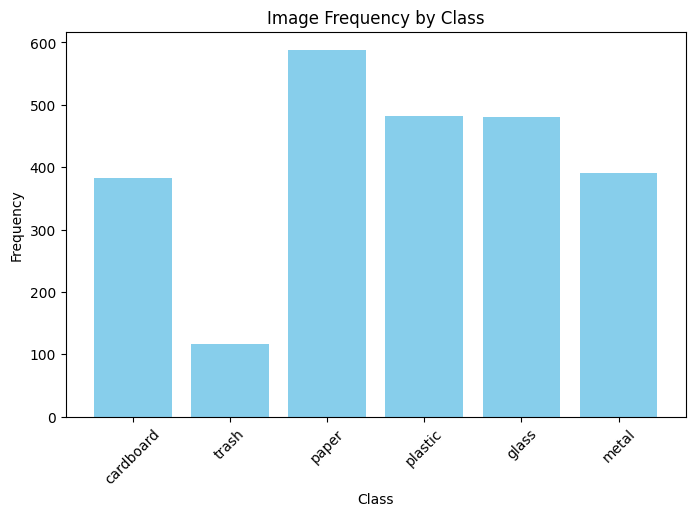

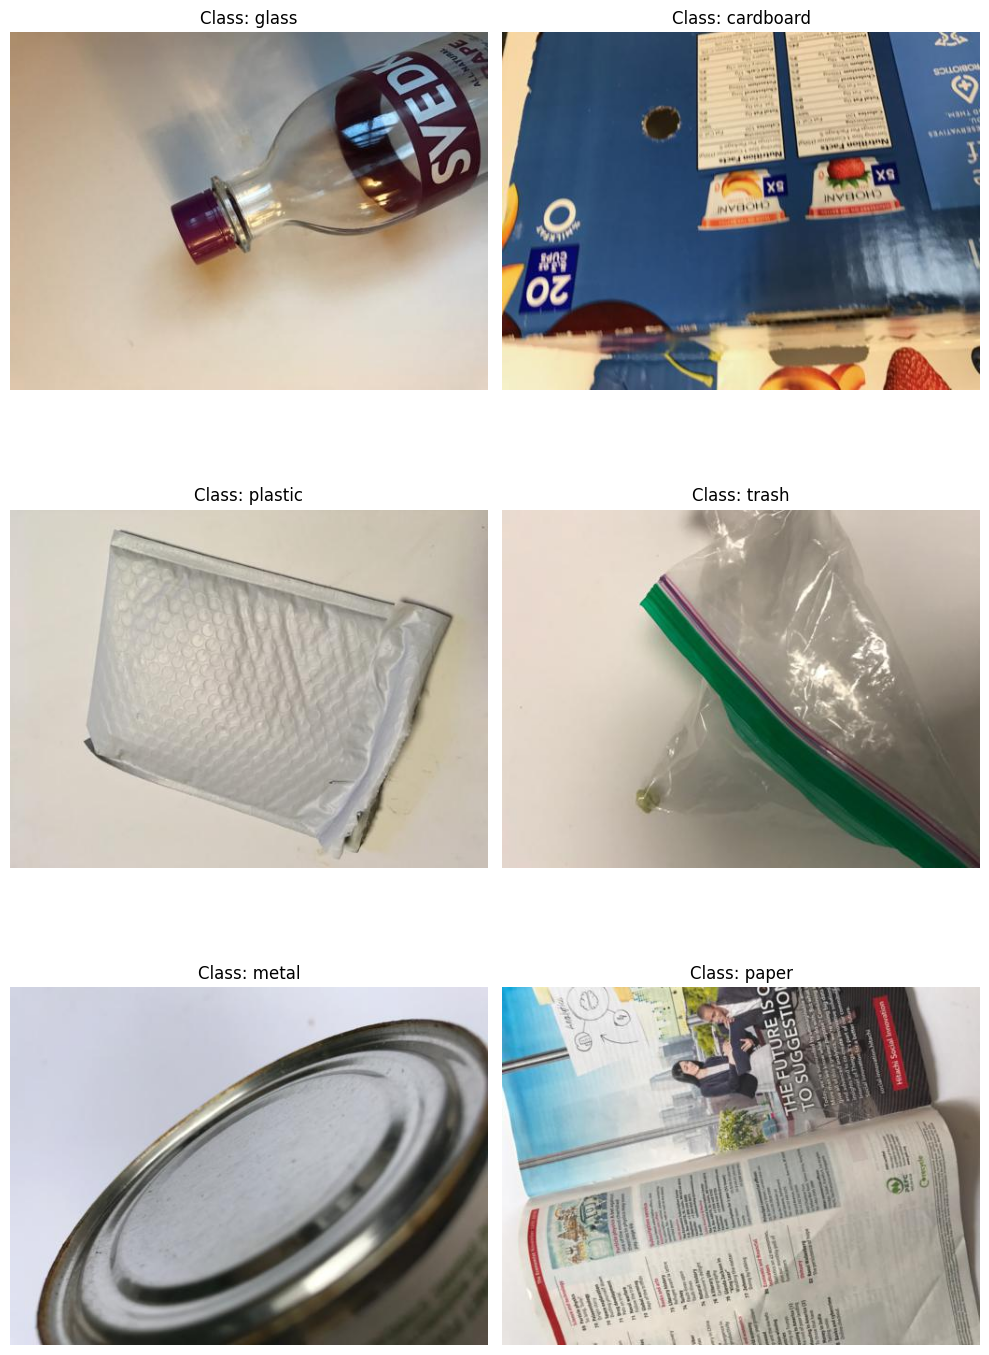

In [ ]:
import cv2

# Function to load the dataset from the directory
def load_dataset_from_directory(base_dir):
    dataset = {"images": [], "labels": []}
    class_names = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    dataset["images"].append(image)
                    dataset["labels"].append(class_name)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
    return dataset

# Function to count image frequencies
def count_image_frequencies(dataset):
    counts = Counter(dataset["labels"])
    print("\nImage Frequencies:")
    for label, count in counts.items():
        print(f"{label}: {count}")

    print("\nImage Frequencies (Percentage):")
    for label, count in counts.items():
        percentage = (count / len(dataset["labels"])) * 100
        print(f"{label}: {percentage:.3f}%")

    print("\nExample Image Sizes by Class:")
    for label in counts.keys():
        # Find the first image of the current class
        idx = dataset["labels"].index(label)
        image_size = dataset["images"][idx].shape
        print(f"{label}: {image_size}")

    return counts

# Function to plot the bar chart of image frequencies
def plot_image_frequencies(label_counts):
    labels, frequencies = zip(*label_counts.items())
    plt.figure(figsize=(8, 5))
    plt.bar(labels, frequencies, color="skyblue")
    plt.title("Image Frequency by Class")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

def visualize_random_images(dataset):
    unique_labels = list(set(dataset["labels"]))  # Get unique class labels
    num_classes = min(len(unique_labels), 6)  # Limit to 6 unique classes for 3x2 grid

    # Ensure exactly 6 classes (repeat some if fewer than 6 unique classes)
    selected_labels = random.sample(unique_labels, num_classes)
    while len(selected_labels) < 6:
        selected_labels.append(random.choice(unique_labels))

    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    axes = axes.ravel()  # Flatten the axes for easier indexing

    for ax, label in zip(axes, selected_labels):
        # Get indices for the current class
        indices = [i for i, lbl in enumerate(dataset["labels"]) if lbl == label]
        # Select a random index for the class
        rand_idx = random.choice(indices)
        image = dataset["images"][rand_idx]

        ax.imshow(image)
        ax.set_title(f"Class: {label}")
        ax.axis("off")

    # Turn off any unused axes
    for ax in axes[len(selected_labels):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Load the dataset
dataset = load_dataset_from_directory(base_dir)

# Count image frequencies
label_counts = count_image_frequencies(dataset)

# Plot image frequencies
plot_image_frequencies(label_counts)

# Visualize random images
visualize_random_images(dataset)

Based on the result of outputting the dataset distribution, image shape, and plotting the images, I can conclude that:
1. The dataset is highly imbalanced, with the label (trash) being less than 5% of the total dataset.
2. The distribution of images is not uniform. Not only is the label class a minority, the rest fluctuates.
3. Images are already uniform in shape, which is good. As the standard of computer vision size is (224, 224), I will simply resize the image to that.


Given the result of this analysis, I have some ideas and thoughts to address the dataset imbalance as well as preprocessing:
1. Undersampling majority classes is out of question as although the images fluctuates, 588 images from 6 classes is not much. Undersampling will only cause information loss.
2. I will use augmentation, class weights manipulation, and focal loss implementation. This method pushes the model to pay attention to minority classes.
3. A simple preprocessing of image normalization should suffice.
4. I will employ transfer learning for faster and more efficient training.

Partitioning the Test Set

---

Since the dataset is small, I will take 20 images from every class for test set, and the rest will be split into an 80:20 train-val split.

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

test_dir = '/content/drive/MyDrive/Colab Notebooks/adamata/test_set'
os.makedirs(test_dir, exist_ok=True)

# Move 20 images per class to the test set
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    # Skip the 'test_set' directory and any non-directory files
    if class_name == 'test_set' or not os.path.isdir(class_path):
        continue

    # Create corresponding class directory in test_set
    test_class_path = os.path.join(test_dir, class_name)
    os.makedirs(test_class_path, exist_ok=True)

    # Get list of all images in this class
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Check if there are at least 20 images
    if len(images) < 20:
        print(f/Skipping class '{class_name}' as it contains less than 20 images./)
        continue

    # Split 20 images for test
    test_images, remaining_images = train_test_split(images, test_size=len(images) - 20, random_state=123)

    # Move test images
    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_class_path, img))

print(/Test set created successfully!/)

Test set created successfully!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False
)

print('Data generators generated.')

Found 2146 images belonging to 6 classes.
Found 534 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
Data generators generated.


Transfer Learning

---

Transfer Learning is a technique that employs pretrained models. For this task, I will use MobileNetV2, pretrained on the ImageNet dataset. The reason are as follows:
1. The MobileNet family is developed for edge device deployments. In a trash classification application based in Indonesia, I would **assume** that the application will be deployed to CCTVs, making MobileNet the perfect candidate.
2. MobileNetV2 is a widely used model in general, known for its speed and performance. I have used this method and model numerous times myself.
3. The ImageNet dataset is a world-wide challenge on X number of classifications. Since the TrashNet dataset contains bottles, papers, etc., the pretrained weights will significantly help the model.

In [ ]:
# MobileNetV2 Model
from tensorflow.keras.applications import MobileNetV2

# load MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False

# base_model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

def create_model():
    model = tf.keras.models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(512, activation = 'relu'),
        Dense(6, activation='softmax')
    ])

    return model

baseline_model = create_model()
focal_model = create_model()

baseline_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,101,702 (15.65 MB)

 Trainable params: 1,841,670 (7.03 MB)

 Non-trainable params: 2,260,032 (8.62 MB)

Callbacks and Custom Loss

---

The callbacks used will be the ModelCheckpoint and ReduceLROnPlateau. The Focal Loss will be my custom loss function.

Focal Loss is ...

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Set checkpoint path
checkpoint_path = 'model_checkpoint.keras'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max',
    verbose = 1
)

# Reduce learning rate on plateau
lr_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    verbose = 1,
    factor = 0.1,
    min_lr = 0.000001
)

def focal_loss(alpha=None, gamma=2.0):
    """
    Focal Loss for Multi-Class Classification.

    Parameters:
        alpha: List of class weights or None. Defaults to no class weighting.
        gamma: Focusing parameter.

    Returns:
        A loss function compatible with TensorFlow/Keras.
    """
    def loss_fn(y_true, y_pred):
        # Apply softmax to y_pred
        y_pred = tf.nn.softmax(y_pred, axis=-1)

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Compute cross-entropy term
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Compute the modulating term
        modulating_factor = tf.pow(1 - y_pred, gamma)

        # If alpha is provided, gather corresponding class weights
        if alpha is not None:
            alpha_tensor = tf.constant(alpha, dtype=tf.float32)
            alpha_t = tf.gather(alpha_tensor, tf.argmax(y_true, axis=-1))
            alpha_t = tf.reshape(alpha_t, (-1, 1))  # Reshape to (batch_size, 1)
        else:
            alpha_t = 1.0  # No weighting

        # Combine all terms
        focal_loss = alpha_t * modulating_factor * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))  # Sum over classes, average over batch

    return loss_fn

WandB for Experiment Tracking

---

In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: viansbromokusumo (vian-library). Use `wandb login --relogin` to force relogin


True

In [ ]:
from tensorflow import keras
from wandb.integration.keras import WandbCallback

# Initialize WandB
wandb.init(
    project='experiment-tracking1',
    name='baseline_vs_focal_loss',
    config={
        'learning_rate': 0.001,
        'batch_size': 64,
        'epochs': 15,
        'loss_function': 'focal_loss' if 'focal_model' in locals() else 'categorical_crossentropy',
        'image_size': 224,
        'augmentation': {
            'rotation_range': 30,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'shear_range': 0.2,
            'zoom_range': 0.2,
            'horizontal_flip': True,
            'vertical_flip': True,
        },
    }
)

METRICS = [
      keras.metrics.CategoricalCrossentropy(name='cross entropy'),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

# Compile model with focal loss
baseline_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=wandb.config.learning_rate),
    loss='categorical_crossentropy',
    metrics=METRICS
)

alpha = [1.0, 1.0, 1.0, 1.0, 1.0, 5.0]
focal_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=wandb.config.learning_rate),
    loss=focal_loss(alpha=alpha, gamma=2.0),
    metrics=METRICS
)

Helper Functions

---

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

def visualize_results(y_true, y_pred, title):

    # Classification report for precision, recall, F1 per class
    class_report = classification_report(y_true, y_pred, output_dict=True)
    metrics_df = pd.DataFrame(class_report).transpose()
    print('\nClassification Report:')
    print(metrics_df)

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title(f'\n{title} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return metrics_df

# Logging metrics to WnB
def log_metrics(epoch, history, y_true, y_pred):
    # Calculate precision, recall, F1-score
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    # Log metrics to WnB
    wandb.log({
        'epoch': epoch,
        'train_loss': history.history['loss'][0],
        'val_loss': history.history['val_loss'][0],
        'train_accuracy': history.history['accuracy'][0],
        'val_accuracy': history.history['val_accuracy'][0],
        'precision_macro': precision_macro,
        'precision_micro': precision_micro,
        'recall_macro': recall_macro,
        'recall_micro': recall_micro,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    })

Model Training

---

For the model training, I will experiment on three types:
1. Baseline
  - Backbone : MobileNetV2
  - Loss : Categorical Cross Entropy
  - Class Weights Manipulation : Disabled
2. Baseline_ClassW
  - Backbone : MobileNetV2
  - Loss : Categorical Cross Entropy
  - Class Weights Manipulation : Enabled
3. Focal Loss Model
  - Backbone : MobileNetV2
  - Loss : Focal Loss
  - Class Weights Manipulation : Enabled

34/34 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - Brier score: 0.0876 - accuracy: 0.8854 - auc: 0.8811 - cross entropy: 1.1411 - fn: 422.2286 - fp: 280.5428 - loss: 1.1411 - prc: 0.6924 - precision: 0.6769 - recall: 0.5643 - tn: 5384.6001 - tp: 710.8000 - val_Brier score: 0.0733 - val_accuracy: 0.8970 - val_auc: 0.9275 - val_cross entropy: 0.8723 - val_fn: 206.0000 - val_fp: 124.0000 - val_loss: 0.8723 - val_prc: 0.7732 - val_precision: 0.7257 - val_recall: 0.6142 - val_tn: 2546.0000 - val_tp: 328.0000
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 961ms/step - Brier score: 0.0432 - accuracy: 0.9406 - auc: 0.9750 - cross entropy: 0.4961 - fn: 233.4857 - fp: 178.5714 - loss: 0.4961 - prc: 0.9080 - precision: 0.8370 - recall: 0.7991 - tn: 5495.1431 - tp: 901.2571 - val_Brier score: 0.0627 - val_accuracy: 0.9151 - val_auc: 0.9433 - val_cross entropy: 0.7464 - val_fn: 176.0000 - val_fp: 96.0000 - val_loss: 0.7464 - val_prc: 0.8157 - val_precision: 0.7885 - val_recall: 0.6704 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.800000  0.888889   20.000000
1              0.941176  0.800000  0.864865   20.000000
2              0.826087  0.950000  0.883721   20.000000
3              0.888889  0.800000  0.842105   20.000000
4              0.760000  0.950000  0.844444   20.000000
5              0.714286  0.750000  0.731707   20.000000
accuracy       0.841667  0.841667  0.841667    0.841667
macro avg      0.855073  0.841667  0.842622  120.000000
weighted avg   0.855073  0.841667  0.842622  120.000000


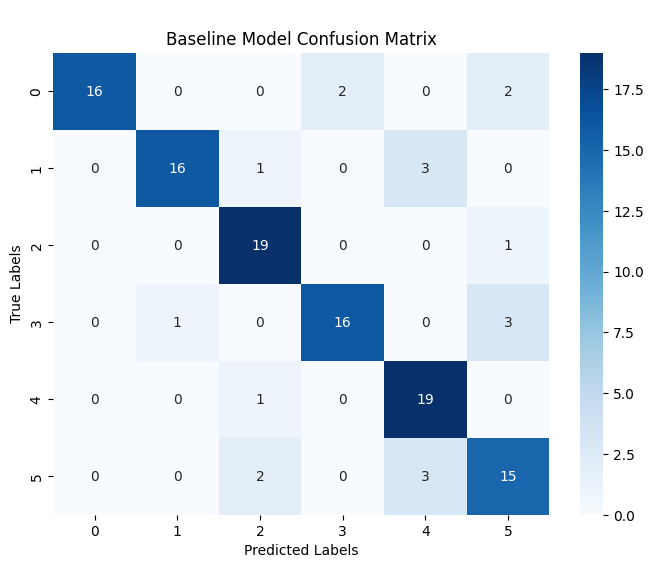

In [ ]:
# BASELINE MODEL TRAINING LOOP
for epoch in range(wandb.config.epochs):
    history_baseline = baseline_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,
        verbose=1
    )

    # Predict validation set labels
    y_pred = np.argmax(baseline_model.predict(val_generator), axis=-1)
    y_true = val_generator.labels  # Ensure correct format

    # Log metrics
    log_metrics(epoch, history_baseline, y_true, y_pred)

# performance check
y_pred = np.argmax(baseline_model.predict(test_generator), axis=-1)
y_true = test_generator.labels

metrics_df = visualize_results(y_true, y_pred, 'Baseline Model')

Surprisingly, the baseline model has a good performance already. Let's observe will other strategies further improve this performance.

34/34 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - Brier score: 0.0925 - accuracy: 0.8790 - auc: 0.8661 - cross entropy: 1.2049 - fn: 454.7714 - fp: 288.8286 - loss: 1.4912 - prc: 0.6586 - precision: 0.6537 - recall: 0.5327 - tn: 5402.0288 - tp: 683.4000 - val_Brier score: 0.1132 - val_accuracy: 0.8477 - val_auc: 0.8719 - val_cross entropy: 1.3237 - val_fn: 274.0000 - val_fp: 214.0000 - val_loss: 1.3237 - val_prc: 0.5946 - val_precision: 0.5485 - val_recall: 0.4869 - val_tn: 2456.0000 - val_tp: 260.0000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 943ms/step - Brier score: 0.0490 - accuracy: 0.9347 - auc: 0.9671 - cross entropy: 0.5680 - fn: 254.0857 - fp: 192.0000 - loss: 0.6716 - prc: 0.8793 - precision: 0.8214 - recall: 0.7775 - tn: 5490.2856 - tp: 882.3714 - val_Brier score: 0.0750 - val_accuracy: 0.9001 - val_auc: 0.9262 - val_cross entropy: 0.9773 - val_fn: 179.0000 - val_fp: 141.0000 - val_loss: 0.9773 - val_prc: 0.7742 - val_precision: 0.7157 - val_recall: 0.6648

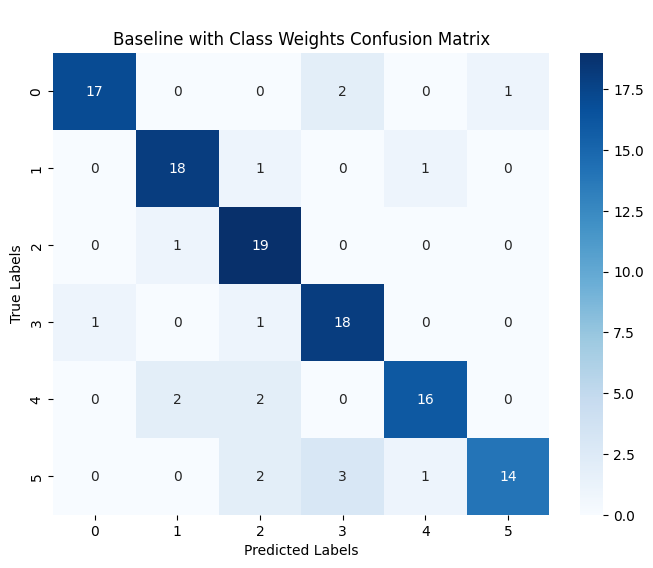

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(generator, class_weights=None):
    """
    Get class weights for training. Can either use default behavior to compute based on frequency
    or use provided weights.

    Parameters:
        generator: ImageDataGenerator flow object, used for class distribution.
        class_weights: dict or None, optional pre-defined class weights.

    Returns:
        dict: A dictionary of class weights for training.
    """
    if class_weights is not None:  # Use predefined class weights if provided
        return class_weights

    # Otherwise, compute class weights automatically
    labels = np.concatenate([generator[i][1].argmax(axis=1) for i in range(len(generator))])
    unique_classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels)
    return {i: weights[i] for i in range(len(weights))}

use_custom_weights = True
custom_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 5} if use_custom_weights else None
class_weights = get_class_weights(train_generator, class_weights=custom_weights)

baseline_classw = create_model()

# Compile model with focal loss
baseline_classw.compile(
    optimizer=tf.optimizers.Adam(learning_rate=wandb.config.learning_rate),
    loss='categorical_crossentropy',
    metrics=METRICS
)

# BASELINE + CLASSWEIGHTS TRAINING LOOP
for epoch in range(wandb.config.epochs):
    hist_baseline_classw = baseline_classw.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,
        verbose=1,
        class_weight=class_weights
    )

    # Predict validation set labels
    y_pred = np.argmax(baseline_classw.predict(val_generator), axis=-1)
    y_true = val_generator.labels  # Ensure correct format

    # Log metrics
    log_metrics(epoch, hist_baseline_classw, y_true, y_pred)

# performance check
y_pred = np.argmax(baseline_classw.predict(test_generator), axis=-1)
y_true = test_generator.labels

metrics_df = visualize_results(y_true, y_pred, 'Baseline with Class Weights')

Although this model is able to predict other classes better, its performance in classifying the label degraded.

34/34 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - Brier score: 0.0439 - accuracy: 0.9488 - auc: 0.9526 - cross entropy: 1.2211 - fn: 265.4000 - fp: 240.7429 - loss: 0.7114 - prc: 0.8652 - precision: 0.8524 - recall: 0.8377 - tn: 8047.2573 - tp: 1392.2000 - val_Brier score: 0.0751 - val_accuracy: 0.9201 - val_auc: 0.8861 - val_cross entropy: 3.4986 - val_fn: 129.0000 - val_fp: 127.0000 - val_loss: 0.8606 - val_prc: 0.7217 - val_precision: 0.7613 - val_recall: 0.7584 - val_tn: 2543.0000 - val_tp: 405.0000
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 628ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 945ms/step - Brier score: 0.0412 - accuracy: 0.9547 - auc: 0.9469 - cross entropy: 1.5464 - fn: 153.9714 - fp: 151.7714 - loss: 0.6886 - prc: 0.8597 - precision: 0.8648 - recall: 0.8631 - tn: 5483.3716 - tp: 973.0571 - val_Brier score: 0.0789 - val_accuracy: 0.9157 - val_auc: 0.8828 - val_cross entropy: 3.8517 - val_fn: 135.0000 - val_fp: 135.0000 - val_loss: 0.8989 - val_prc: 0.7104 - val_precision: 0.7472 - val_recall: 0.747

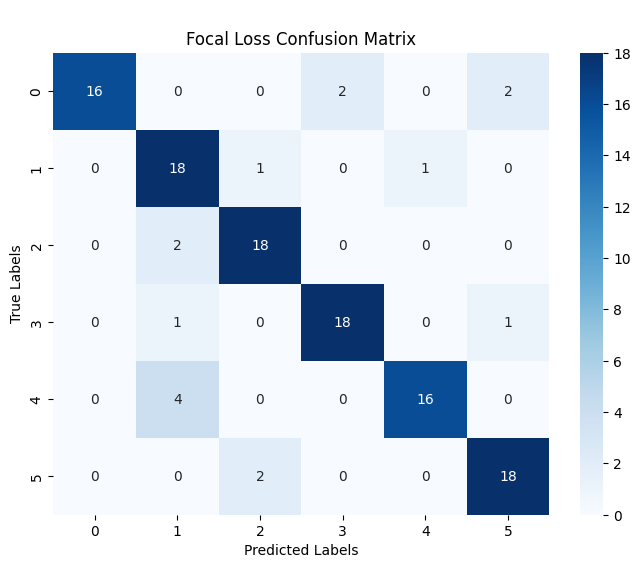

In [ ]:
# FOCAL LOSS TRAINING LOOP
for epoch in range(wandb.config.epochs):
    history_focal = focal_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,
        verbose=1
    )

    # Predict validation set labels
    y_pred = np.argmax(focal_model.predict(val_generator), axis=-1)
    y_true = val_generator.labels  # Ensure correct format

    # Log metrics
    log_metrics(epoch, history_focal, y_true, y_pred)

# performance check
y_pred = np.argmax(focal_model.predict(test_generator), axis=-1)
y_true = test_generator.labels

metrics_df2 = visualize_results(y_true, y_pred, 'Focal Loss')

Here the model has improved. It can be concluded the Focal Loss gave good improvements.

Saving the models.

---

In [ ]:
os.makedirs('/content/drive/MyDrive/Colab Notebooks/adamata/saved_models', exist_ok=True)

# Save the models
baseline_model.save('saved_models/baseline_model.keras')
baseline_classw.save('saved_models/baseline_classw.keras')
focal_model.save('saved_models/focal_model.keras')

print('Models saved successfully!')

Models saved successfully!


Based on the experimentations, my approach proved to be a good solution in classifying trash from 6 classes. Further improvements that I can think of would be as follows:

1. Hyperparameter Tuning on models' architecture, functions' parameterizations, etc.
2. Performing Quantization and other optimization methods for deployments
3. If the scope is not specifically classifying trash **types**, it is possible to make a binary classification dataset into Trash and Non-Trash. This will give a larger binary classification dataset and by partitioning the dataset into a cross-validation style training, a more robust model can be developed.
4. Applying advanced data balancing techniques such as GANs, image oversampling, etc., to diversify the dataset. Although, computational, energy, and time costs must be considered for this suggestion. It all comes down to the iterative goals of the application.

In [2]:
from google.colab import files
files.download('requirements.txt')
print('requirements.txt downloaded')
!python --version

requirements.txt downloaded
Python 3.10.12
